In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

# **Getting "stopwords" from nltk library**

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [4]:
#loading dataset
news_dataset = pd.read_csv('/content/drive/MyDrive/fake_news_train.csv')

In [5]:
news_dataset.shape

(20800, 5)

In [6]:
news_dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:
news_dataset['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


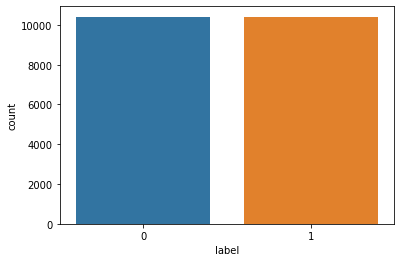

In [8]:
sns.countplot(news_dataset['label'])

# **Counting the number of missing values**

In [9]:
news_dataset.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

# **Replacing null values with empty string**

In [10]:
news_dataset = news_dataset.fillna('')
# or you can use news_dataset.dropna()

# Merging author and title

In [11]:
news_dataset['content'] = news_dataset['author']+' '+news_dataset['title']

In [12]:
news_dataset['content']

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object

# Separating the data and label

In [13]:
x = news_dataset.drop('label', axis=1)
y = news_dataset['label']

# **Stemming** 
**Stemming** is the process of reducing a word to its root word

**Example:**

 - actor, actress, acting --> act

In [14]:
port_stem = PorterStemmer()

In [15]:
def stemming(content):
  # regular expression for searching in content column for alphapet only(replace all numbers,commas..etc with ' ') and store it to new variable
  stemmed_content = re.sub('[^a-zA-Z]',' ', content) 
  # convert all words to lowercase
  stemmed_content = stemmed_content.lower()
  # split all words to a list 
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [16]:
# apply stemming func to content column
news_dataset['content'] = news_dataset['content'].apply(stemming)

In [17]:
print(news_dataset['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


# Store **content** to x and calling y(**label**)

In [18]:
x = news_dataset['content'].values
y = news_dataset['label'].values

In [19]:
print(x)
print(y)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']
[1 0 1 ... 0 1 1]


# Converting textual '**content**' to numeircal data 

**TF** stands for "**Term frequency**":

 - It counts the number of times a particular word is repeating in the document, 
repetition tells that the repeated word is very important word and assign a particular value to this word.

**idf** stands for "**inverse document frequency**":

 - A repeated word that doen't have meaning like searching for "Avengers" in a document have lots of words called "Avengers" so we reduce it.

**Example:**

 - Consider a document containing 100 words wherein the word cat appears 3 times. The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

In [20]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x)

x = vectorizer.transform(x)

In [21]:
print(x)

  (0, 15686)	0.28485063562728646
  (0, 13473)	0.2565896679337957
  (0, 8909)	0.3635963806326075
  (0, 8630)	0.29212514087043684
  (0, 7692)	0.24785219520671603
  (0, 7005)	0.21874169089359144
  (0, 4973)	0.233316966909351
  (0, 3792)	0.2705332480845492
  (0, 3600)	0.3598939188262559
  (0, 2959)	0.2468450128533713
  (0, 2483)	0.3676519686797209
  (0, 267)	0.27010124977708766
  (1, 16799)	0.30071745655510157
  (1, 6816)	0.1904660198296849
  (1, 5503)	0.7143299355715573
  (1, 3568)	0.26373768806048464
  (1, 2813)	0.19094574062359204
  (1, 2223)	0.3827320386859759
  (1, 1894)	0.15521974226349364
  (1, 1497)	0.2939891562094648
  (2, 15611)	0.41544962664721613
  (2, 9620)	0.49351492943649944
  (2, 5968)	0.3474613386728292
  (2, 5389)	0.3866530551182615
  (2, 3103)	0.46097489583229645
  :	:
  (20797, 13122)	0.2482526352197606
  (20797, 12344)	0.27263457663336677
  (20797, 12138)	0.24778257724396507
  (20797, 10306)	0.08038079000566466
  (20797, 9588)	0.174553480255222
  (20797, 9518)	0.295420

# Split data to train and test

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=2)

# Training the model

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [24]:
model = {
    "LR": LogisticRegression(),
    "KNNC": KNeighborsClassifier(),
    "SVC": SVC(),
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "XGBC": XGBClassifier(),
}

# Evaluation
**Accuracy score**

 - Compare predicted values to actual values

In [25]:
for name, model in model.items():
  print(f'Using model: {name}')
  model.fit(x_train,y_train)
  x_train_prediction = model.predict(x_train)
  x_test_prediction = model.predict(x_test)
  print(f'Training Accuracy Score: {accuracy_score(x_train_prediction , y_train)}')
  print(f'Testing Accuracy Score: {accuracy_score(x_test_prediction , y_test)}')
  print('=============================================')


Using model: LR
Training Accuracy Score: 0.9865985576923076
Testing Accuracy Score: 0.9790865384615385
Using model: KNNC
Training Accuracy Score: 0.5360576923076923
Testing Accuracy Score: 0.5233173076923077
Using model: SVC
Training Accuracy Score: 0.9990985576923077
Testing Accuracy Score: 0.9889423076923077
Using model: DT
Training Accuracy Score: 1.0
Testing Accuracy Score: 0.9915865384615384
Using model: RF
Training Accuracy Score: 1.0
Testing Accuracy Score: 0.9932692307692308
Using model: XGBC
Training Accuracy Score: 0.9594350961538461
Testing Accuracy Score: 0.953125


# Making a Predictive system

In [26]:
x_new = x_test[0]

prediction = model.predict(x_new)
print(prediction)

if(prediction[0] == 0):
  print('Real news')
else:
  print('Fake news')

[1]
Fake news


In [27]:
print(y_test[0])

1
